# ydata를 이미지 데이터로부터 추출한 feature로 사용하여 학습시킨 코드입니다.
* x,y data 모두 numpy array 형태로 들어갑니다.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import os
import random
import time

import warnings
import cv2
import matplotlib.pyplot as plt

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

# 내가 사용할 GPU번호(0,1,2,3)
os.environ["CUDA_VISIBLE_DEVICES"]="1"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus: 
    try: # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus: 
            tf.config.experimental.set_memory_growth(gpu, True)
            
        logical_gpus = tf.config.experimental.list_logical_devices('GPU') 
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
    
    except RuntimeError as e: # Memory growth must be set before GPUs have been initialized 
        print(e)
        

class config:
    seed = 13
    
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(config.seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
!ls

10models-2.ipynb  MOLD_Pantspress_V3_image.csv	ydata.npy
10models.ipynb	  cross_validation.ipynb


In [ ]:
y = np.load('ydata.npy')

In [ ]:
df = pd.read_csv('./MOLD_Pantspress_V3_image.csv')

In [ ]:
# 불필요 feature(컬럼) 제거

drop_list = ['No', 'Run', 'PJT', 'Thickness']

df.drop(drop_list, axis=1, inplace=True)

In [ ]:
df.shape

(375, 25)

In [ ]:
cols = df.columns
x_s = cols[:-10]
x_df = df[x_s]

In [ ]:
x_df.head()

,P/N,Material,Width_O,Height_O,Depth_O,Width_I,Height_I,Depth_I,Hot Runner,Gate size,Time(sec),Pack(MPa),Pack(sec),Melt Temp,Mold Temp
0,MDQ63916801,ABS,344.2,653.5,22.3,133.0,431.2,22.6,35,3,3,30,1,225,60
1,MDQ63916801,ABS,344.2,653.5,22.3,133.0,431.2,22.6,45,3,3,30,1,225,40
2,MDQ63916801,ABS,344.2,653.5,22.3,133.0,431.2,22.6,35,5,3,30,1,225,40
3,MDQ63916801,ABS,344.2,653.5,22.3,133.0,431.2,22.6,45,5,3,30,1,225,60
4,MDQ63916801,ABS,344.2,653.5,22.3,133.0,431.2,22.6,35,3,5,30,1,225,40


In [ ]:
# onehot encoding 적용할 컬럼 목록
onehot_cols = ['P/N', 'Material']

# onehot encoding
df_onehot = pd.get_dummies(x_df[onehot_cols], prefix=['P/N', 'Material'])

# 기준을 위해 저장
x_material = x_df['Material']

# 기존 컬럼 삭제
x_df.drop(['P/N', 'Material'], axis=1, inplace=True)

x_df = pd.concat([x_df, df_onehot], axis=1)

y_col = ['distance_up','deg_up','xp_up','yp_up','distance_down','deg_down','xp_down','yp_down']
y_df = pd.DataFrame(y, columns=y_col)
df = pd.concat([x_df, y_df], axis=1)

/home/kang/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
y_df.to_csv('./ydata.csv',index=False)

In [ ]:
x_df.shape

(375, 18)

In [ ]:
x_df.head()

,Width_O,Height_O,Depth_O,Width_I,Height_I,Depth_I,Hot Runner,Gate size,Time(sec),Pack(MPa),Pack(sec),Melt Temp,Mold Temp,P/N_MDQ63916801,P/N_MDQ64980001,Material_ABS,Material_ASA,Material_PCR
0,344.2,653.5,22.3,133.0,431.2,22.6,35,3,3,30,1,225,60,1,0,1,0,0
1,344.2,653.5,22.3,133.0,431.2,22.6,45,3,3,30,1,225,40,1,0,1,0,0
2,344.2,653.5,22.3,133.0,431.2,22.6,35,5,3,30,1,225,40,1,0,1,0,0
3,344.2,653.5,22.3,133.0,431.2,22.6,45,5,3,30,1,225,60,1,0,1,0,0
4,344.2,653.5,22.3,133.0,431.2,22.6,35,3,5,30,1,225,40,1,0,1,0,0


In [ ]:
df_onehot.shape

(375, 5)

In [ ]:
y_df.shape

(375, 8)

In [ ]:
y_df.head()

,distance_up,deg_up,xp_up,yp_up,distance_down,deg_down,xp_down,yp_down
0,29.849606,38.418055,43.0,45.0,35.930112,44.090620,149.0,61.0
1,37.705386,48.468229,32.0,42.0,35.566253,32.969404,143.0,51.0
2,24.843422,35.753887,50.0,47.0,33.250852,39.093859,151.0,61.0
3,21.168395,40.364537,48.0,47.0,35.930112,45.909380,152.0,62.0
4,30.357307,39.610688,43.0,45.0,37.911804,38.088773,146.0,56.0


In [ ]:
df.shape

(375, 26)

In [ ]:
df.head()

,Width_O,Height_O,Depth_O,Width_I,Height_I,Depth_I,Hot Runner,Gate size,Time(sec),Pack(MPa),...,Material_ASA,Material_PCR,distance_up,deg_up,xp_up,yp_up,distance_down,deg_down,xp_down,yp_down
0,344.2,653.5,22.3,133.0,431.2,22.6,35,3,3,30,...,0,0,29.849606,38.418055,43.0,45.0,35.930112,44.090620,149.0,61.0
1,344.2,653.5,22.3,133.0,431.2,22.6,45,3,3,30,...,0,0,37.705386,48.468229,32.0,42.0,35.566253,32.969404,143.0,51.0
2,344.2,653.5,22.3,133.0,431.2,22.6,35,5,3,30,...,0,0,24.843422,35.753887,50.0,47.0,33.250852,39.093859,151.0,61.0
3,344.2,653.5,22.3,133.0,431.2,22.6,45,5,3,30,...,0,0,21.168395,40.364537,48.0,47.0,35.930112,45.909380,152.0,62.0
4,344.2,653.5,22.3,133.0,431.2,22.6,35,3,5,30,...,0,0,30.357307,39.610688,43.0,45.0,37.911804,38.088773,146.0,56.0


In [ ]:
def label_encoding(df):
    le = LabelEncoder()
    original_columns = list(df.columns)
    
    for col in df:
        # df의 컬럼의 유형이 object인 것들만
        if df[col].dtype == 'object':
            le.fit(df[col])
            df[col] = le.transform(df[col])

    # 새롭게 만들어진 컬럼들의 이름을 리스트로 저장
    new_columns = [c for c in df.columns if c not in original_columns]
    
    # 수치형으로 변경된 df와 새롭게 만들어진 컬럼 이름 리스트를 반환
    return df, new_columns

df_2, new_cols = label_encoding(df)

cols = list(df_2.columns)

df_2['Material'] = x_material

train, test = train_test_split(df_2, test_size=0.2, stratify=x_material, random_state=13)

train.to_csv('./MOLD_final_train.csv', index=False)
test.to_csv('./MOLD_final_test.csv', index=False)

In [ ]:
df_2, new_cols = label_encoding(df)

In [ ]:
df_2.tail()

,Width_O,Height_O,Depth_O,Width_I,Height_I,Depth_I,Hot Runner,Gate size,Time(sec),Pack(MPa),...,Material_PCR,distance_up,deg_up,xp_up,yp_up,distance_down,deg_down,xp_down,yp_down,Material
370,344.2,653.5,22.3,133.0,431.2,22.6,45,5,3,50,...,0,18.283523,41.423666,47.0,47.0,31.410229,48.122130,152.0,64.0,1
371,344.2,653.5,22.3,133.0,431.2,22.6,35,3,5,50,...,0,36.513650,43.210089,43.0,45.0,35.013376,38.453709,151.0,61.0,1
372,344.2,653.5,22.3,133.0,431.2,22.6,45,3,5,50,...,0,41.943237,37.971604,49.0,47.0,32.748291,37.998732,150.0,60.0,1
373,344.2,653.5,22.3,133.0,431.2,22.6,35,5,5,50,...,0,43.875711,36.027373,52.0,48.0,40.811551,37.775684,153.0,64.0,1
374,344.2,653.5,22.3,133.0,431.2,22.6,45,5,5,50,...,0,42.098010,36.430858,49.0,47.0,36.495834,45.000000,154.0,64.0,1


In [ ]:
cols = list(df_2.columns)
# cols

In [ ]:
def regression_model(output_num=1, n_neuron=256):
    model = Sequential()
    model.add(Flatten())
    
    model.add(Dense(n_neuron, activation='relu'))
    model.add(Dense(n_neuron, activation='relu'))
    model.add(Dense(n_neuron, activation='relu'))
    model.add(Dense(n_neuron, activation='relu'))
    model.add(Dense(n_neuron, activation='relu'))

    model.add(Dense(output_num, activation='linear'))
    
    return model

In [ ]:
x_s = cols[:-9]
x_s

Index(['Width_O', 'Height_O', 'Depth_O', 'Width_I', 'Height_I', 'Depth_I',
       'Hot Runner', 'Gate size', 'Time(sec)', 'Pack(MPa)', 'Pack(sec)',
       'Melt Temp', 'Mold Temp', 'P/N_MDQ63916801', 'P/N_MDQ64980001',
       'Material_ABS', 'Material_ASA', 'Material_PCR'],
      dtype='object')

In [ ]:
train, valid = train_test_split(df, test_size=0.2,  random_state=13)
cols = df.columns

In [ ]:
x_train = train[cols[:-9]]
# y_train = train[cols[col_index]]
x_train.shape

(300, 18)

In [ ]:
df_2 = pd.read_csv('./MOLD_final_train.csv')

x_material = df_2['Material']

train, valid = train_test_split(df_2, test_size=0.2, stratify=x_material, random_state=13)
cols = df_2.columns

In [ ]:
x_s = cols[:-9]

for col_index in range(-9, -1, 1):
    
    scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    y_col_name = cols[col_index]
    x_train = train[x_s]
    y_train = train[y_col_name]
    
    y_train = np.array(y_train)
    y_train = y_train.reshape(-1, 1)

    scaler.fit(x_train)
    y_scaler.fit(y_train)
    
    num_folds = 3
    
    folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=13)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_2[x_s], df_2['Material'])):
        x_train, y_train = df_2[x_s].iloc[train_idx], df_2[y_col_name].iloc[train_idx]
        x_valid, y_valid = df_2[x_s].iloc[valid_idx], df_2[y_col_name].iloc[valid_idx]
        
        y_train = np.array(y_train)
        y_valid = np.array(y_valid)
        
        y_train = y_train.reshape(-1, 1)
        y_valid = y_valid.reshape(-1, 1)
        
        x_train = scaler.transform(x_train)
        y_train = y_scaler.transform(y_train)
        
        x_valid = scaler.transform(x_valid)
        y_valid = y_scaler.transform(y_valid)
        
        model = regression_model()

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                     loss='mse',
                     metrics='mae')

        checkpoint_filepath = './models/best_model_%s_fold%d.h5' % (y_col_name, n_fold)

        mc = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=0, save_best_only=True,
                            mode='auto')
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        model.fit(x_train, y_train, epochs=2000, validation_data=(x_valid, y_valid), batch_size=8, callbacks=[es, mc], verbose=0)

        best_model = tf.keras.models.load_model('./models/best_model_%s_fold%d.h5' % (y_col_name, n_fold))
        
        pred = best_model.predict(x_valid)

        y_valid = y_scaler.inverse_transform(y_valid)
        pred = y_scaler.inverse_transform(pred)

        res = []
        for i in range(pred.shape[0]):
            res.append(abs(y_valid[i] - pred[i]) / y_valid[i])    
        print('fold%d error rate: ' % (n_fold), np.round(np.mean(res) * 100, 3))

fold0 error rate:  7.809
fold1 error rate:  7.394
fold2 error rate:  13.8
fold0 error rate:  4.877
fold1 error rate:  3.703
fold2 error rate:  4.645
fold0 error rate:  2.031
fold1 error rate:  1.569
fold2 error rate:  1.815
fold0 error rate:  1.022
fold1 error rate:  1.518
fold2 error rate:  1.095
fold0 error rate:  6.984
fold1 error rate:  8.51
fold2 error rate:  9.244
fold0 error rate:  2.912
fold1 error rate:  3.864
fold2 error rate:  4.241
fold0 error rate:  1.869
fold1 error rate:  1.549
fold2 error rate:  1.196
fold0 error rate:  2.075
fold1 error rate:  1.8
fold2 error rate:  1.546


In [ ]:
x_s = cols[:-9]

for col_index in range(-9, -1, 1):
    
    x_train = train[cols[:-9]]
    y_train = train[cols[col_index]]

    x_valid = valid[cols[:-9]]
    y_valid = valid[cols[col_index]]
    
    y_train = np.array(y_train)
    y_valid = np.array(y_valid) 
#     y_train = np.array(train_y)
#     y_valid = np.array(valid_y) 
    
    y_train = y_train.reshape(-1, 1)
    y_valid = y_valid.reshape(-1, 1)

#     col_name = cols['distance_up','deg_up','xp_up','yp_up','distance_down','deg_down','xp_down','yp_down']
    col_name = cols[col_index]
    
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_valid = scaler.transform(x_valid)

    y_scaler = MinMaxScaler()

    y_train = y_scaler.fit_transform(y_train)
    y_valid = y_scaler.transform(y_valid)

    model = regression_model()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                 loss='mse',
                 metrics='mae')

#     checkpoint_filepath = './best_model_%s_fold%d.h5' % (col_name, n_fold)
    checkpoint_filepath = './best_model_%s.h5' % (col_name)

    mc = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=0, save_best_only=True,
                        mode='auto')
    es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    model.fit(x_train, y_train, epochs=500, validation_data=(x_valid, y_valid), batch_size=16, callbacks=[es, mc], verbose=0)

#     best_model = tf.keras.models.load_model('./best_model_%s_fold%d.h5' % (col_name, n_fold))
    best_model = tf.keras.models.load_model('./best_model_%s.h5' % (col_name))

    pred = best_model.predict(x_valid)

    y_valid = y_scaler.inverse_transform(y_valid)
    pred = y_scaler.inverse_transform(pred)

#     print(y_valid.shape)
#     print(pred.shape)

    res = []
    for i in range(pred.shape[0]):
        res.append(abs(y_valid[i] - pred[i]) / y_valid[i])    
    print('error rate: ', np.round(np.mean(res) * 100, 3))
        
#     print('fold%d error rate: ' % (n_fold), np.round(np.mean(res) * 100, 3))
    
#     features = [i for i in range(10)]
#     ress = []

#     for feature in features:
#         res = []
#         for i in range(pred.shape[0]):
#             res.append(abs(y_valid[i, feature] - pred[i, feature]) / y_valid[i, feature])
#         ress.append(np.mean(res) * 100)
    
#     result_df = pd.DataFrame(data=np.round(ress, 3), index=cols[-10:], columns=['error_rate'])    
#     print(result_df)

error rate:  8.994
error rate:  5.223
error rate:  1.879
error rate:  1.356
error rate:  5.249
error rate:  4.818
error rate:  1.568
error rate:  1.642


In [ ]:
#test
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

train_df = pd.read_csv('MOLD_final_train.csv')
cols = train_df.columns

scaler = MinMaxScaler()
x_train = train[x_s]

scaler.fit(x_train)
    
res_all2 = []
y_cols = []

for col_index in range(-9, -1, 1):
    y_scaler = MinMaxScaler()
    y_col_name = cols[col_index]
    y_cols.append(y_col_name)
    y_train = train[y_col_name]
    y_train = np.array(y_train)
    y_train = y_train.reshape(-1, 1)
    y_scaler.fit(y_train)
    
    test_df = pd.read_csv('MOLD_final_test.csv')
    test_cols = test_df.columns
    test_col_name = test_cols[col_index]
    pred_all = np.zeros((test_df.shape[0], 1))
    ress = []
 
    for n_fold in range(3):
        best_model = tf.keras.models.load_model('./models/best_model_%s_fold%d.h5' % (test_col_name, n_fold))
        
        x_test = test_df[test_cols[:-9]]
        y_test = test_df[test_col_name]

        y_test = np.array(y_test)
        y_test = y_test.reshape(-1, 1)

        x_test = scaler.transform(x_test)
        y_test = y_scaler.transform(y_test)

        pred = best_model.predict(np.expand_dims(x_test, axis=1))

        y_test = y_scaler.inverse_transform(y_test)
        pred = y_scaler.inverse_transform(pred)

#         res = []

#         for i in range(pred.shape[0]):
#             res.append(abs(y_test[i] - pred[i]) / y_test[i])  
#         print('fold%d error rate: ' % (n_fold), np.round(np.mean(res) * 100, 3))
#         ress.append(np.mean(res) * 100)

        pred_all += pred
        
#         result_df = pd.DataFrame(data=np.round(ress, 3), columns=[f'{test_col_name} error_rate'])
        
#     display(result_df)
    
    final_pred = pred_all / 3
    
    res_all = []
    for i in range(pred.shape[0]):
        res_all.append(abs(y_test[i] - final_pred[i]) / y_test[i])
    print('error rate: ', np.round(np.mean(res_all) * 100, 3))

#     res_all = []
    res_all2.append(np.round(np.mean(res_all) * 100, 3))
        
#     print(f'Final {y_col_name} error rate: ', np.round(np.mean(res_all) * 100, 3))
#     res_all2.append(abs(y_test[i] - final_pred[i]) / y_test[i])
    
#     print('' * 100)
#     print('*' * 70)
print(res_all2)
print(y_cols)

# result_all_df = pd.DataFrame(np.array(res_all2).reshape(-1, 1), columns=y_cols)
result_all_df = pd.DataFrame([res_all2], columns=y_cols)

display(result_all_df)

result_acc_ls = [f'{(100 - res_all2[i]).round(2)}%' for i in range(8)]
result_acc_df = pd.DataFrame([result_acc_ls], columns=y_cols)

display(result_acc_df)
#     result_all_df = pd.DataFrame(data=np.round(ress, 3), columns=[f'{test_col_name} error_rate'])

error rate:  9.324
error rate:  5.889
error rate:  1.539
error rate:  0.911
error rate:  7.818
error rate:  3.078
error rate:  1.088
error rate:  1.512
[9.324, 5.889, 1.539, 0.911, 7.818, 3.078, 1.088, 1.512]
['distance_up', 'deg_up', 'xp_up', 'yp_up', 'distance_down', 'deg_down', 'xp_down', 'yp_down']


,distance_up,deg_up,xp_up,yp_up,distance_down,deg_down,xp_down,yp_down
0,9.324,5.889,1.539,0.911,7.818,3.078,1.088,1.512


,distance_up,deg_up,xp_up,yp_up,distance_down,deg_down,xp_down,yp_down
0,90.68%,94.11%,98.46%,99.09%,92.18%,96.92%,98.91%,98.49%


In [ ]:
# input index
x_s

Index(['Width_O', 'Height_O', 'Depth_O', 'Width_I', 'Height_I', 'Depth_I',
       'Hot Runner', 'Gate size', 'Time(sec)', 'Pack(MPa)', 'Pack(sec)',
       'Melt Temp', 'Mold Temp', 'P/N_MDQ63916801', 'P/N_MDQ64980001',
       'Material_ABS', 'Material_ASA', 'Material_PCR'],
      dtype='object')

In [ ]:
test_df = pd.read_csv('MOLD_final_test.csv')
test_df = pd.read_csv('MOLD_final_test.csv')
test_cols = test_df.columns
test_col_name = test_cols[col_index]

In [ ]:
def essence():
    import copy
    coef = 500/(982-362)
    
    testimg1 = copy.deepcopy(eu)
    xpu = int(xp_up)
    ypu = int(yp_up)
    p1 = (xpu, ypu)
    rad = deg_up*np.pi/180
    dx1 = int(distance_up/coef * np.cos(rad))
    dy1 = int(distance_up/coef * np.sin(rad))
    p2 = (xpu+dx1,ypu-dy1)
    a = cv2.line(testimg1, p1,p2,(255,0,0), thickness=2)

    testimg2 = copy.deepcopy(ed)
    xpd = int(xp_down)
    ypd = int(yp_down)
    p3 = (xpd, ypd)
    rad = deg_down*np.pi/180
    dx2 = int(distance_down * np.cos(rad))
    dy2 = int(distance_down * np.sin(rad))
    p4 = (xpd-dx2,ypd+dy2)
    b = cv2.line(testimg2, p3,p4,(255,0,0), thickness=2)
    plt.subplot(121)
    plt.imshow(a)
    plt.subplot(122)
    plt.imshow(b)
    plt.show()

In [ ]:
def baron():
    import copy
    coef = 500/(982-362)
    
    testimg1 = copy.deepcopy(bu)
    xpu = int(xp_up)
    ypu = int(yp_up)
    p1 = (xpu, ypu)
    rad = deg_up*np.pi/180
    dx1 = int(distance_up/coef * np.cos(rad))
    dy1 = int(distance_up/coef * np.sin(rad))
    p2 = (xpu-dx1,ypu-dy1)
    a = cv2.line(testimg1, p1,p2,(255,0,0), thickness=2)

    testimg2 = copy.deepcopy(bd)
    xpd = int(xp_down)
    ypd = int(yp_down)
    p3 = (xpd, ypd)
    rad = deg_down*np.pi/180
    dx2 = int(distance_down * np.cos(rad))
    dy2 = int(distance_down * np.sin(rad))
    p4 = (xpd+dx2,ypd+dy2)
    b = cv2.line(testimg2, p3,p4,(255,0,0), thickness=2)
    plt.subplot(121)
    plt.imshow(a)
    plt.subplot(122)
    plt.imshow(b)
    plt.show()
    

In [ ]:
eu = cv2.imread('./essence_up.jpg')
ed = cv2.imread('./essence_down.jpg')
bu = cv2.imread('./baron_up.jpg')
bd = cv2.imread('./baron_down.jpg')

In [ ]:
model1 = tf.keras.models.load_model('./models/best_model_distance_up_fold0.h5')
model2 = tf.keras.models.load_model('./models/best_model_deg_up_fold0.h5')
model3 = tf.keras.models.load_model('./models/best_model_xp_up_fold0.h5')
model4 = tf.keras.models.load_model('./models/best_model_yp_up_fold0.h5')
model5 = tf.keras.models.load_model('./models/best_model_distance_down_fold0.h5')
model6 = tf.keras.models.load_model('./models/best_model_deg_down_fold0.h5')
model7 = tf.keras.models.load_model('./models/best_model_xp_down_fold0.h5')
model8 = tf.keras.models.load_model('./models/best_model_yp_down_fold0.h5')

In [ ]:
x_test = test_df[test_cols[:-9]]

In [ ]:
xt = np.array(x_test)
xt

array([[491.4, 703.5,  23. , ...,   0. ,   1. ,   0. ],
       [491.4, 703.5,  23. , ...,   1. ,   0. ,   0. ],
       [344.2, 653.5,  22.3, ...,   1. ,   0. ,   0. ],
       ...,
       [344.2, 653.5,  22.3, ...,   0. ,   0. ,   1. ],
       [491.4, 703.5,  23. , ...,   0. ,   1. ,   0. ],
       [344.2, 653.5,  22.3, ...,   0. ,   1. ,   0. ]])

In [ ]:
# input : xtest
xtt = scaler.transform(xt)
xx = xtt[0]
xx

array([1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
       0.])

In [ ]:
x=np.expand_dims(xx, axis=0)
x, x[0][13]

(array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 0.]]),
 0.0)

* 간단히 보기위해 앙상블을 사용하지 않고 모델 1개로만 예측하여 보여주는 부분입니다.

In [ ]:
distance_up = model1.predict(x) # model1_2.predict(x)+.../3
deg_up = model2.predict(x)
xp_up = model3.predict(x)
yp_up = model4.predict(x)
distance_down = model5.predict(x) # model1_2.predict(x)+.../3
deg_down = model6.predict(x)
xp_down = model7.predict(x)
yp_down = model8.predict(x)

In [ ]:
test_cols = test_df.columns

In [ ]:
y_scaler = MinMaxScaler()

y_scaler.fit(train_df[test_cols[-9:-1]])

# train_df[test_cols[-9:-1]]

MinMaxScaler()

In [ ]:
np.array([distance_up[0][0], deg_up[0][0]])

array([0.18253686, 0.4448339 ], dtype=float32)

In [ ]:
a = np.array([distance_up[0][0], deg_up[0][0], xp_up[0][0], yp_up[0][0], distance_down[0][0], deg_down[0][0], xp_down[0][0], yp_down[0][0]]).reshape(1, -1)

In [ ]:
predss = y_scaler.inverse_transform(a)

In [ ]:
predss

array([[ 25.921705,  36.447845, 160.07182 ,  71.73783 ,  31.747557,
         40.82158 ,  43.976646,  47.16542 ]], dtype=float32)

In [ ]:
dist

array([[38.02371623, 46.67951885, 60.9477399 , 61.73782766, 46.04885659,
        43.52675238, 35.23958459, 47.16542023]])

In [ ]:
distance_up = predss[0][0]
deg_up = predss[0][1]
xp_up = predss[0][2]
yp_up = predss[0][3]

distance_down = predss[0][4]
deg_down = predss[0][5]
xp_down = predss[0][6]
yp_down = predss[0][7]

In [ ]:
print(distance_up, deg_up, xp_up, yp_up)
print(distance_down, deg_down, xp_down, yp_down)


25.921705 36.447845 160.07182 71.73783
31.747557 40.82158 43.976646 47.16542


* weld line의 각종 예측 feature를 출력합니다.

In [ ]:
print(f'윗부분weld line길이 : {distance_up:.2f}mm')
print(f'윗부분weld line각도 : {deg_up:.2f}도')
print(f'아랫부분weld line길이 : {distance_down:.2f}mm')
print(f'아랫부분weld line각도 : {deg_down:.2f}도')

윗부분weld line길이 : 25.92mm
윗부분weld line각도 : 36.45도
아랫부분weld line길이 : 31.75mm
아랫부분weld line각도 : 40.82도


* opencv라이브러리를 이용하여 essence일 경우와 baron일 경우를 구분하여 그림을 그려주는 코드입니다.

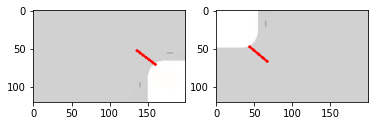

In [ ]:
if x[0][13]==1: #essence
    essence()
else:
    baron()
    
    